In [1]:
import time
import os

import jax
import numpy as np

import matplotlib.pyplot as plt

# disabling hardware accelerators warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

import qibo
from qibo import Circuit, gates, hamiltonians
from qiboml.operations import expectation
from qiboml.operations import differentiation

%load_ext autotime
%load_ext memory_profiler

time: 2.62 ms (started: 2024-05-07 17:14:20 +02:00)


In [2]:
def build_parametric_circuit(nqubits, nlayers):
    """Build a Parametric Quantum Circuit with Qibo."""
    c = Circuit(nqubits)
    for _ in range(nlayers):
        for q in range(nqubits):
            c.add(gates.RY(q=q, theta=0))
            c.add(gates.RZ(q=q, theta=0))
        for q in range(0, nqubits-1, 1):
            c.add(gates.CNOT(q0=q, q1=q+1))
        c.add(gates.CNOT(q0=nqubits-1, q1=0))
    c.add(gates.M(*range(nqubits)))

    return c

def build_observable(nqubits):
    """build observable."""
    return hamiltonians.Z(nqubits=nqubits)

time: 802 µs (started: 2024-05-07 17:14:20 +02:00)


In [3]:
nqubits = 3
nlayers = 3
nepochs = 100
random_seed = 42
learning_rate = 0.01

time: 989 µs (started: 2024-05-07 17:14:23 +02:00)


In [4]:
def train(
    nqubits, 
    nlayers, 
    nepochs, 
    learning_rate, 
    qibo_backend="jax", 
    exec_backend="jax",
    jit=True, 
    verbose=True
):
    """Training routine."""

    qibo.set_backend(qibo_backend)
    c = build_parametric_circuit(nqubits, nlayers)
    h = build_observable(nqubits)

    if verbose:
        print(c.draw())

    np.random.seed(42)
    parameters = np.random.randn(len(c.get_parameters()))
    

    def cost_function(params):
        """Cost function wrapper."""
        c.set_parameters(params)
        exp = expectation.expectation(
            observable=h, circuit=c, backend=exec_backend,
            )
        return exp

    if jit:
        if qibo_backend == "jax":
            cost_function = jax.jit(cost_function)

    it = time.time()
    if qibo_backend == "jax":
        dcost = jax.grad(cost_function)

        for epoch in range(nepochs):
            gradients = dcost(parameters)
            cost = cost_function(parameters)
            if (epoch % 10 == 0) and verbose is True:
                print(f"Cost: {cost:.4} \t |\t Epoch: {epoch}")
            parameters -= learning_rate * gradients 

    if qibo_backend == "tensorflow":        
        for epoch in range(nepochs):
            with tf.GradientTape() as tape:
                parameters = tf.Variable(parameters)
                cost = cost_function(parameters)
            if (epoch % 10 == 0) and verbose is True:
                print(f"Cost: {cost:.4} \t |\t Epoch: {epoch}")
            gradients = tape.gradient(cost, parameters)
            parameters = parameters.assign_sub(learning_rate * gradients)
    ft = time.time()
    return (ft-it)

time: 4.07 ms (started: 2024-05-07 17:14:26 +02:00)


In [5]:
NQ = np.arange(2, 9, 1)
nepochs = 20

jax_times = []
tf_times = []
qibojit_times = []

for n in NQ:
    jax_times.append(train(
        nqubits=int(n), 
        nlayers=int(n), 
        nepochs=nepochs, 
        learning_rate=learning_rate, 
        qibo_backend="jax",
        exec_backend="jax",
        verbose=False
        )
    )
    tf_times.append(train(
        nqubits=int(n), 
        nlayers=int(n), 
        nepochs=nepochs, 
        learning_rate=learning_rate, 
        qibo_backend="tensorflow",
        exec_backend="tensorflow",
        verbose=False
        )
    )

[Qibo 0.2.8|INFO|2024-05-07 11:23:52]: Using jax backend on /CPU:0
[Qibo 0.2.8|INFO|2024-05-07 11:23:53]: Using tensorflow backend on /device:CPU:0
[Qibo 0.2.8|INFO|2024-05-07 11:23:54]: Using jax backend on /CPU:0
[Qibo 0.2.8|INFO|2024-05-07 11:23:55]: Using tensorflow backend on /device:CPU:0
[Qibo 0.2.8|INFO|2024-05-07 11:23:56]: Using jax backend on /CPU:0
[Qibo 0.2.8|INFO|2024-05-07 11:23:59]: Using tensorflow backend on /device:CPU:0
[Qibo 0.2.8|INFO|2024-05-07 11:24:01]: Using jax backend on /CPU:0
[Qibo 0.2.8|INFO|2024-05-07 11:24:06]: Using tensorflow backend on /device:CPU:0
[Qibo 0.2.8|INFO|2024-05-07 11:24:09]: Using jax backend on /CPU:0
[Qibo 0.2.8|INFO|2024-05-07 11:24:18]: Using tensorflow backend on /device:CPU:0
[Qibo 0.2.8|INFO|2024-05-07 11:24:22]: Using jax backend on /CPU:0
[Qibo 0.2.8|INFO|2024-05-07 11:24:37]: Using tensorflow backend on /device:CPU:0
[Qibo 0.2.8|INFO|2024-05-07 11:24:43]: Using jax backend on /CPU:0
[Qibo 0.2.8|INFO|2024-05-07 11:25:07]: Using 

time: 9min 55s (started: 2024-05-07 11:23:52 +02:00)


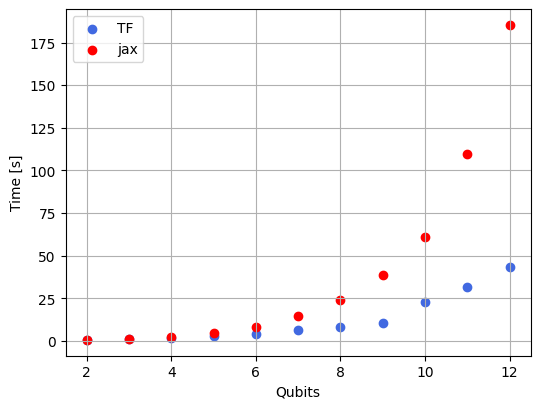

time: 1.8 s (started: 2024-05-07 11:33:59 +02:00)


In [7]:
plt.figure(figsize=(6, 6*6/8))
plt.scatter(np.arange(2,13,1), tf_times, label="TF", color="royalblue")
plt.scatter(np.arange(2,13,1), jax_times, label="jax", color="red")
plt.grid("True")
plt.legend()
plt.xlabel("Qubits")
plt.ylabel("Time [s]")
plt.savefig("jax_tf_train.png", dpi=1200)
plt.show()

In [61]:
jax_times

[None, None, None, None, None, None]

time: 4.19 ms (started: 2024-05-07 11:06:04 +02:00)


In [8]:
%%memit
train(nqubits, nlayers, nepochs, learning_rate, "jax")

/home/matteo/anaconda3/envs/eqibo/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[Qibo 0.2.8|INFO|2024-05-07 13:17:08]: Using jax backend on /CPU:0


q0: ─RY─RZ─o───X─RY─RZ─o───X─RY─RZ─o───X─M─
q1: ─RY─RZ─X─o─|─RY─RZ─X─o─|─RY─RZ─X─o─|─M─
q2: ─RY─RZ───X─o─RY─RZ───X─o─RY─RZ───X─o─M─


/home/matteo/anaconda3/envs/eqibo/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Cost: -0.9762 	 |	 Epoch: 0
Cost: -1.482 	 |	 Epoch: 10
peak memory: 2059.69 MiB, increment: 0.12 MiB
time: 2.01 s (started: 2024-05-07 13:17:07 +02:00)


In [6]:
train(nqubits=4, 
        nlayers=4, 
        nepochs=10, 
        learning_rate=0.01, 
        qibo_backend="jax",
        exec_backend="jax",
        verbose=True,
        jit=True
        )

[Qibo 0.2.8|INFO|2024-05-07 17:15:33]: Using jax backend on /CPU:0


q0: ─RY─RZ─o─────X─RY─RZ─o─────X─RY─RZ─o─────X─RY─RZ─o─────X─M─
q1: ─RY─RZ─X─o───|─RY─RZ─X─o───|─RY─RZ─X─o───|─RY─RZ─X─o───|─M─
q2: ─RY─RZ───X─o─|─RY─RZ───X─o─|─RY─RZ───X─o─|─RY─RZ───X─o─|─M─
q3: ─RY─RZ─────X─o─RY─RZ─────X─o─RY─RZ─────X─o─RY─RZ─────X─o─M─
Cost: -0.3661 	 |	 Epoch: 0


2.719146251678467

time: 2.74 s (started: 2024-05-07 17:15:33 +02:00)
